In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models
from PIL import Image, ImageFile
from typing import Tuple, Dict, List
from tqdm import tqdm 
from tabulate import tabulate
from timeit import default_timer as timer
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import yaml

# Enable loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
class CFG:
    debug = False
    device = "cuda"
    seed = 42
    classes = [
        "Fire_Disaster",
        "Human_Damage",
        "Water_Disaster",
        "Land_Disaster",
        "Damaged_Infrastructure",
        "Non_Damage"
    ]
    path = "/kaggle/input/disaster/Comprehensive Disaster Dataset(CDD)"
    batch_size = 64
    num_workers = 2
    split = [0.65, 0.20, 0.15]
    input_size = [224, 224]
    num_epochs = 25
    
    if debug:
        num_epochs = 5
        
    if not torch.cuda.is_available():
        device = "cpu"

In [3]:
class ImageFolderCustom(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, target_transform=None) -> None:
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.data = []
        self.targets = []
        self.load_data()

    def load_data(self):
        class_names = os.listdir(self.root)
        for i, class_name in enumerate(class_names):
            class_dir = os.path.join(self.root, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                try:
                    image = Image.open(image_path)
                except Exception as e:
                    continue
                self.data.append(image)
                self.targets.append(float(image_name[1:2])-1)

    def __getitem__(self, index: int) -> tuple:
        img, target = self.data[index], self.targets[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self) -> int:
        return len(self.data)

In [4]:
def get_data(path: str) -> Tuple[torch.utils.data.Dataset, List[str]]:
    transform = transforms.Compose([
        transforms.Resize(CFG.input_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3] if x.size(0) > 3 else x),
        transforms.Lambda(lambda x: x.expand(3, -1, -1) if x.size(0) == 1 else x)
    ])
    target_transform = transforms.Lambda(lambda y: torch.tensor(y, dtype=torch.long))

    dataset = ImageFolderCustom(path, transform=transform, target_transform=target_transform)

    return dataset

In [5]:
def get_dataloader(dataset: torch.utils.data.Dataset) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, CFG.split)

    train_dataloader = DataLoader(train_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)

    return train_dataloader, test_dataloader, valid_dataloader

In [6]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset):
    n = 5
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(15, 15))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample]
        targ_image_adjust = targ_image.permute(1, 2, 0)
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        title = f"class: {CFG.classes[(targ_label)]}"
        plt.title(title)

In [7]:
def get_model(model: nn.Module, pretrained: bool = True, load: bool = False) -> nn.Module:
    # Load the pre-trained model
    model_instance = model(pretrained=pretrained)

    if isinstance(model_instance, models.resnet.ResNet):
        num_ftrs = model_instance.fc.in_features
        model_instance.fc = nn.Linear(num_ftrs, len(CFG.classes)).to(CFG.device)
    else:
        raise NotImplementedError("Model type not supported for automatic modification of classifier layer.")

    if load:
        model_instance.load_state_dict(torch.load(f="./model_1.pth"))

    return model_instance

In [8]:
def train_func(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, device: None):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [9]:
def validation_func(data_loader: DataLoader, model: nn.Module, loss_fn: nn.Module, device: None):
    valid_loss, valid_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            valid_pred = model(X)
            valid_loss += loss_fn(valid_pred, y)
            valid_acc += accuracy_fn(y_true=y, y_pred=valid_pred.argmax(dim=1))
        valid_loss /= len(data_loader)
        valid_acc /= len(data_loader)
        return valid_loss, valid_acc

In [10]:
def pred_func(data_loader: DataLoader, model: nn.Module, loss_fn: nn.Module, device: None):
    eval_loss, eval_acc = 0, 0
    model.to(device)
    model.eval()
    y_preds = []
    y_targets = []
    with torch.inference_mode():
        for batch, (X, y) in tqdm(enumerate(data_loader)):
            X, y = X.to(device), y.to(device)
            eval_pred = model(X)
            eval_loss += loss_fn(eval_pred, y)
            eval_acc += accuracy_fn(y_true=y, y_pred=eval_pred.argmax(dim=1))
            eval_labels = torch.argmax(torch.softmax(eval_pred, dim=1), dim=1)
            y_preds.append(eval_labels)
            y_targets.append(y)

        eval_loss /= len(data_loader)
        eval_acc /= len(data_loader)

        y_preds = torch.cat(y_preds).cpu()
        y_targets = torch.cat(y_targets).cpu()

        f1 = f1_score(y_targets, y_preds, average='macro')

        return {"model_name": model.__class__.__name__,
                "loss": eval_loss.item(),
                "accuracy": eval_acc,
                "f1_score": f1,
                "predictions": y_preds,
                "targets": y_targets}

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [12]:
def print_train_time(start: float, end: float, device: CFG.device):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [13]:
def train_and_evaluate(train_dataloader: torch.utils.data.DataLoader,
                       valid_dataloader: torch.utils.data.DataLoader,
                       model: torch.nn.Module,
                       loss_fn: torch.nn.Module,
                       optimizer: torch.optim.Optimizer,
                       device: None):

    class_names = CFG.classes
    train_time_start_model_1 = timer()
    best_loss = 10
    results = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for epoch in tqdm(range(CFG.num_epochs)):
        train_loss, train_acc = train_func(data_loader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)
        valid_loss, valid_acc = validation_func(data_loader=valid_dataloader, model=model, loss_fn=loss_fn, device=device)
        print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {valid_loss:.3f} | Test acc: {valid_acc:.2f}")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        if valid_loss < best_loss:
            best_loss = valid_loss
            print(f"Saving best model for epoch: {epoch}")
            torch.save(obj=model.state_dict(), f="./model_1.pth")
    train_time_end_model_1 = timer()
    total_train_time_model_1 = print_train_time(start=train_time_start_model_1, end=train_time_end_model_1, device=device)
    return results

In [14]:
def plot_loss_curves(results: Dict[str, List]):
    loss = [x.item() for x in results['train_loss']]
    valid_loss = [x.item() for x in results['valid_loss']]

    accuracy = results['train_acc']
    valid_accuracy = results['valid_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, valid_loss, label='valid_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, valid_accuracy, label='valid_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [15]:
def generate_confusion_matrix(test_results, class_names):
    y_true = test_results['targets']
    y_pred = test_results['predictions']

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [16]:
def generate_classification_report(test_results, class_names):
    y_true = test_results['targets']
    y_pred = test_results['predictions']
    model_name = test_results['model_name']
    accuracy = test_results['accuracy']
    loss = test_results['loss']

    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return report

In [17]:
def merge_train_val(train_dataloader: DataLoader, valid_dataloader: DataLoader) -> DataLoader:
    merged_data = torch.utils.data.ConcatDataset([train_dataloader.dataset, valid_dataloader.dataset])
    merged_dataloader = DataLoader(merged_data, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)
    return merged_dataloader

In [18]:
def cross_validation(merged_dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, num_folds: int = 5):
    kf = KFold(n_splits=num_folds)
    fold_results = []

    for fold, (train_indices, val_indices) in enumerate(kf.split(merged_dataloader.dataset)):
        print(f"Fold {fold + 1}/{num_folds}")
        train_subset = torch.utils.data.Subset(merged_dataloader.dataset, train_indices)
        val_subset = torch.utils.data.Subset(merged_dataloader.dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=CFG.batch_size, num_workers=CFG.num_workers, shuffle=False)

        # Train the model
        model_instance = get_model(model)
        loss_fn= torch.nn.CrossEntropyLoss()
        optimizer_instance = torch.optim.SGD(params=model_instance.parameters(), lr=0.001)
        train_func(data_loader=train_loader,
                   model=model_instance,
                   loss_fn=loss_fn,
                   optimizer=optimizer_instance,
                   device=CFG.device)

        # Evaluate the model on validation data
        loaded_model = get_model(models.resnet50, pretrained=True, load=True)
        val_results = pred_func(data_loader = val_loader,
                                model = loaded_model,
                                loss_fn = loss_fn,
                                device=CFG.device
                                )

        fold_accuracy = val_results["accuracy"]
        fold_f1_score = val_results["f1_score"]
        fold_results.append({"accuracy": fold_accuracy, "f1_score": fold_f1_score})

    return fold_results

In [19]:
def display_comparison_table_iv(test_results, class_names):
    classification_report = generate_classification_report(test_results, class_names)

    extracted_scores_dict = {}
    for class_name, metrics in classification_report.items():
        if class_name not in ['accuracy', 'weighted avg']:
            precision = metrics['precision']
            f1_score = metrics['f1-score']
            extracted_scores_dict[class_name] = {'precision': precision, 'f1_score': f1_score}  # Corrected line

    # Table IV from the paper
    table_iv = {
        'Damaged_Infrastructure': {'CAM-model': {'precision': 0.91, 'f1_score': 0.93}, 'TLAM-model': {'precision': 0.87, 'f1_score': 0.92}},
        'Fire_Disaster': {'CAM-model': {'precision': 1.00, 'f1_score': 0.98}, 'TLAM-model': {'precision': 1.00, 'f1_score': 1.00}},
        'Human_Damage': {'CAM-model': {'precision': 0.91, 'f1_score': 0.92}, 'TLAM-model': {'precision': 0.94, 'f1_score': 0.97}},
        'Water_Disaster': {'CAM-model': {'precision': 1.00, 'f1_score': 1.00}, 'TLAM-model': {'precision': 1.00, 'f1_score': 0.98}},
        'Land_Disaster': {'CAM-model': {'precision': 0.94, 'f1_score': 0.94}, 'TLAM-model': {'precision': 1.00, 'f1_score': 0.94}},
        'Non_Damage': {'CAM-model': {'precision': 0.97, 'f1_score': 0.96}, 'TLAM-model': {'precision': 1.00, 'f1_score': 0.99}},
        'macro avg': {'CAM-model': {'precision': 0.96, 'f1_score': 0.96}, 'TLAM-model': {'precision': 0.97, 'f1_score': 0.97}}
    }

    table_data = []
    for class_name, scores in extracted_scores_dict.items():
        cam_precision = f"{table_iv[class_name]['CAM-model']['precision']:.2f}"
        cam_f1_score = f"{table_iv[class_name]['CAM-model']['f1_score']:.2f}"
        tlam_precision = f"{table_iv[class_name]['TLAM-model']['precision']:.2f}"
        tlam_f1_score = f"{table_iv[class_name]['TLAM-model']['f1_score']:.2f}"
        extracted_precision = f"{scores['precision']:.2f}"
        extracted_f1_score = f"{scores['f1_score']:.2f}"
        table_data.append([class_name, cam_precision, cam_f1_score, tlam_precision, tlam_f1_score, extracted_precision, extracted_f1_score])

    headers = ["Class Names", "CAM Precision", "CAM F1", "TLAM Precision", "TLAM F1", "My Precision", "My F1"]

    print("Comparison of my result with dataset paper's TABLE IV: Performance Summary for CAM and TLAM on Test Data")
    print('Paper Link: https://arxiv.org/pdf/2107.01284v1.pdf')
    print('~' * 112)
    print(tabulate(table_data, headers=headers, tablefmt="pipe"))
    print('~' * 112)

In [20]:
def display_comparison_table_iii(fold_results: List[Dict[str, float]]):
    table_iii = {
        "CAM": {
            "Accuracy": [0.96, 0.96, 0.95, 0.96, 0.96],
            "F1 Score": [0.89, 0.90, 0.89, 0.92, 0.90]
        },
        "TLAM": {
            "Accuracy": [0.96, 0.96, 0.96, 0.97, 0.96],
            "F1 Score": [0.89, 0.88, 0.88, 0.92, 0.88]
        }
    }

    # Prepare the table
    print("Comparison of my fold-wise macro-average with paper's Table III: ross Validation Summary for CAM and TLAM")
    print('Paper Link: https://arxiv.org/pdf/2107.01284v1.pdf')

    print("+" * 80)
    print("| Fold | CAM Accuracy | CAM F1 | TLAM Accuracy | TLAM F1 | My Accuracy | My F1 |")
    print("|------|--------------|--------|---------------|---------|-------------|-------|")
    for fold in range(len(fold_results)):
        cam_accuracy = table_iii["CAM"]["Accuracy"][fold]
        cam_f1 = table_iii["CAM"]["F1 Score"][fold]
        tlam_accuracy = table_iii["TLAM"]["Accuracy"][fold]
        tlam_f1 = table_iii["TLAM"]["F1 Score"][fold]
        my_accuracy = fold_results[fold]["accuracy"] / 100
        my_f1 = fold_results[fold]["f1_score"]
        print(f"|  {fold+1}   |     {cam_accuracy:.2f}     |   {cam_f1:.2f} |      {tlam_accuracy:.2f}     |   {tlam_f1:.2f}  |     {my_accuracy:.2f}    |  {my_f1:.2f} |")
    print("+" * 80)

In [21]:
# Set Seed
torch.manual_seed(CFG.seed)

In [22]:
# Load dataset from specified path
dataset = get_data(CFG.path)

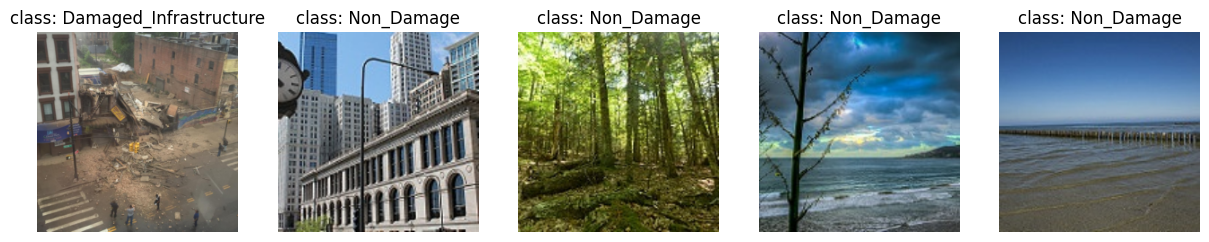

In [23]:
# Display random images from the dataset
display_random_images(dataset)

In [24]:
# Get data loaders for training, testing, and validation
train_dataloader, test_dataloader, valid_dataloader = get_dataloader(dataset)

In [25]:
# Get ResNet model architecture with pretrained weights
resnet_model = get_model(models.resnet50, pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


In [26]:
# Train and evaluate the ResNet model
results = train_and_evaluate(train_dataloader=train_dataloader,
                            valid_dataloader=valid_dataloader,
                            model=resnet_model,
                            loss_fn=torch.nn.CrossEntropyLoss(),
                            optimizer=torch.optim.SGD(params=resnet_model.parameters(), lr=0.001),
                            device=CFG.device
                            )

  4%|▍         | 1/25 [01:31<36:31, 91.30s/it]

Epoch: 0 | Train loss: 0.985 | Train acc: 67.86 | Test loss: 0.788 | Test acc: 70.85
Saving best model for epoch: 0
Epoch: 1 | Train loss: 0.427 | Train acc: 86.08 | Test loss: 0.420 | Test acc: 85.64
Saving best model for epoch: 1


  8%|▊         | 2/25 [03:03<35:13, 91.89s/it]

Epoch: 2 | Train loss: 0.244 | Train acc: 91.96 | Test loss: 0.190 | Test acc: 94.47
Saving best model for epoch: 2


 12%|█▏        | 3/25 [04:35<33:38, 91.76s/it]

Epoch: 3 | Train loss: 0.159 | Train acc: 94.75 | Test loss: 0.162 | Test acc: 95.04
Saving best model for epoch: 3


 16%|█▌        | 4/25 [06:07<32:07, 91.79s/it]

Epoch: 4 | Train loss: 0.140 | Train acc: 95.20 | Test loss: 0.160 | Test acc: 95.14
Saving best model for epoch: 4


 24%|██▍       | 6/25 [09:10<29:01, 91.66s/it]

Epoch: 5 | Train loss: 0.139 | Train acc: 95.48 | Test loss: 0.284 | Test acc: 91.30


 28%|██▊       | 7/25 [10:41<27:27, 91.52s/it]

Epoch: 6 | Train loss: 0.105 | Train acc: 96.52 | Test loss: 0.172 | Test acc: 94.67
Epoch: 7 | Train loss: 0.078 | Train acc: 97.40 | Test loss: 0.139 | Test acc: 95.93
Saving best model for epoch: 7


 32%|███▏      | 8/25 [12:13<25:57, 91.61s/it]

Epoch: 8 | Train loss: 0.064 | Train acc: 97.94 | Test loss: 0.135 | Test acc: 95.67
Saving best model for epoch: 8


 40%|████      | 10/25 [15:16<22:53, 91.58s/it]

Epoch: 9 | Train loss: 0.058 | Train acc: 98.21 | Test loss: 0.154 | Test acc: 95.54


 44%|████▍     | 11/25 [16:47<21:21, 91.54s/it]

Epoch: 10 | Train loss: 0.158 | Train acc: 96.02 | Test loss: 0.678 | Test acc: 76.78


 48%|████▊     | 12/25 [18:19<19:48, 91.41s/it]

Epoch: 11 | Train loss: 0.207 | Train acc: 92.86 | Test loss: 0.169 | Test acc: 94.60


 52%|█████▏    | 13/25 [19:50<18:16, 91.37s/it]

Epoch: 12 | Train loss: 0.063 | Train acc: 97.92 | Test loss: 0.150 | Test acc: 95.22


 56%|█████▌    | 14/25 [21:21<16:44, 91.30s/it]

Epoch: 13 | Train loss: 0.039 | Train acc: 98.77 | Test loss: 0.152 | Test acc: 95.59


 60%|██████    | 15/25 [22:53<15:14, 91.41s/it]

Epoch: 14 | Train loss: 0.030 | Train acc: 98.98 | Test loss: 0.142 | Test acc: 95.92


 64%|██████▍   | 16/25 [24:24<13:43, 91.49s/it]

Epoch: 15 | Train loss: 0.023 | Train acc: 99.38 | Test loss: 0.158 | Test acc: 95.32


 68%|██████▊   | 17/25 [25:56<12:11, 91.48s/it]

Epoch: 16 | Train loss: 0.020 | Train acc: 99.38 | Test loss: 0.168 | Test acc: 95.61


 72%|███████▏  | 18/25 [27:27<10:40, 91.47s/it]

Epoch: 17 | Train loss: 0.017 | Train acc: 99.56 | Test loss: 0.158 | Test acc: 95.97


 76%|███████▌  | 19/25 [28:59<09:09, 91.63s/it]

Epoch: 18 | Train loss: 0.014 | Train acc: 99.52 | Test loss: 0.163 | Test acc: 96.04


 80%|████████  | 20/25 [30:31<07:38, 91.60s/it]

Epoch: 19 | Train loss: 0.012 | Train acc: 99.64 | Test loss: 0.196 | Test acc: 95.41


 84%|████████▍ | 21/25 [32:02<06:06, 91.52s/it]

Epoch: 20 | Train loss: 0.012 | Train acc: 99.59 | Test loss: 0.170 | Test acc: 95.55


 88%|████████▊ | 22/25 [33:33<04:34, 91.50s/it]

Epoch: 21 | Train loss: 0.012 | Train acc: 99.59 | Test loss: 0.185 | Test acc: 95.79


 92%|█████████▏| 23/25 [35:05<03:03, 91.57s/it]

Epoch: 22 | Train loss: 0.013 | Train acc: 99.59 | Test loss: 0.163 | Test acc: 96.08


 96%|█████████▌| 24/25 [36:37<01:31, 91.60s/it]

Epoch: 23 | Train loss: 0.010 | Train acc: 99.64 | Test loss: 0.172 | Test acc: 96.03


100%|██████████| 25/25 [38:09<00:00, 91.57s/it]

Epoch: 24 | Train loss: 0.011 | Train acc: 99.65 | Test loss: 0.173 | Test acc: 96.08
Train time on cuda: 2289.158 seconds


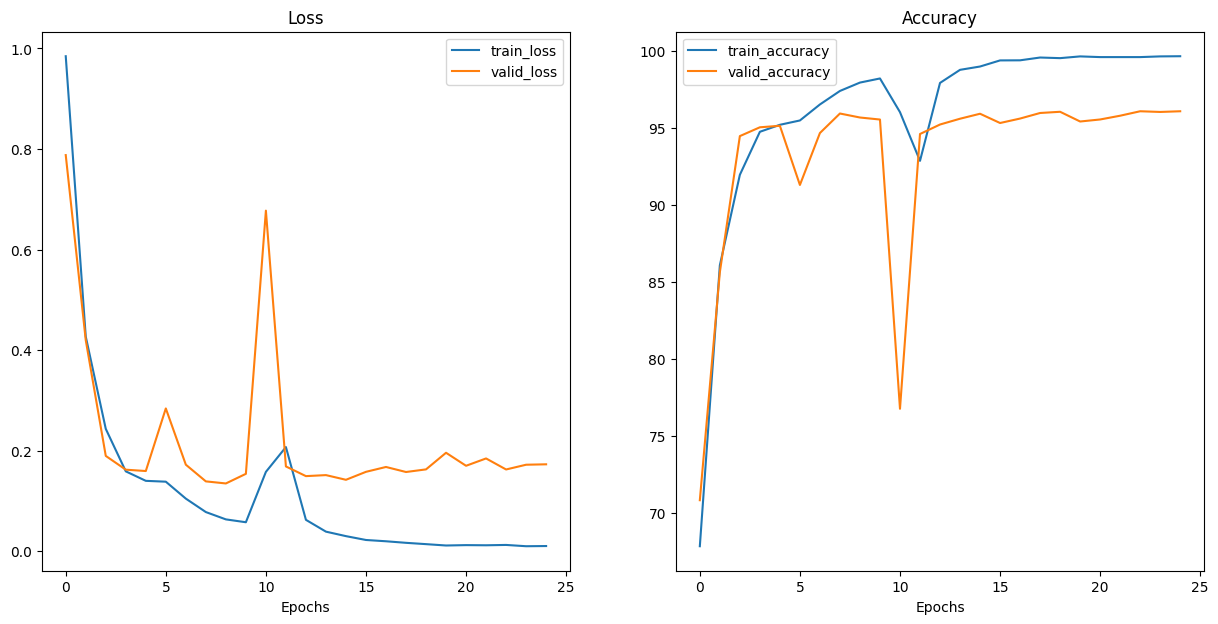

In [27]:
# Plot loss curves based on training and validation results
plot_loss_curves(results)

In [28]:
# Load a pretrained ResNet model
loaded_model = get_model(models.resnet50, pretrained=True, load=True)

# Generate predictions using the loaded model on the test dataset
test_results = pred_func(data_loader=test_dataloader,
                        model=loaded_model,
                        loss_fn=torch.nn.CrossEntropyLoss(),
                        device=CFG.device
                        )

43it [00:13,  3.29it/s]


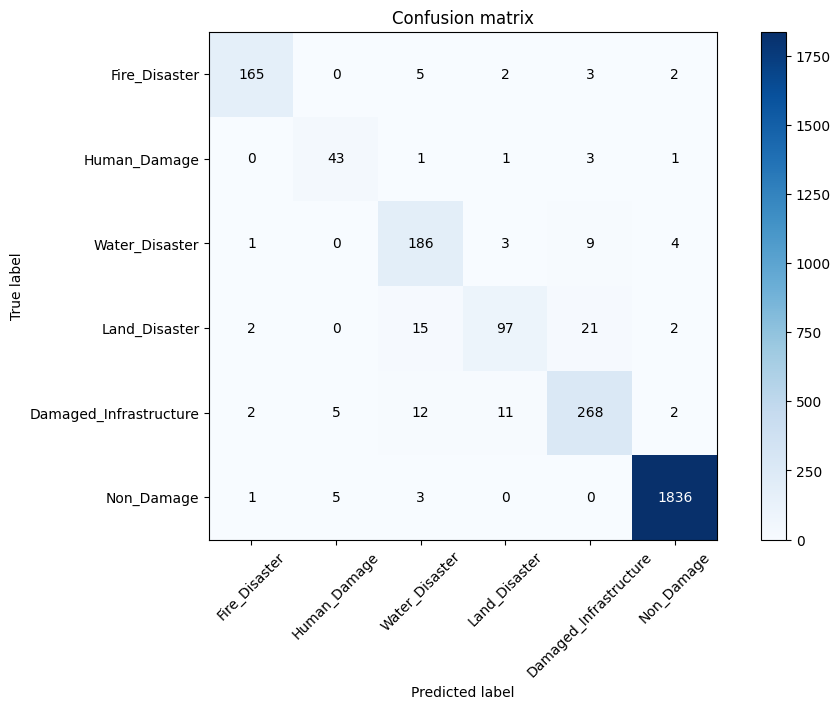

In [29]:
# Generate confusion matrix based on test results and defined classes
generate_confusion_matrix(test_results, CFG.classes)

In [30]:
# Display comparison table for test results
display_comparison_table_iv(test_results, CFG.classes)

Comparison of my result with dataset paper's TABLE IV: Performance Summary for CAM and TLAM on Test Data
Paper Link: https://arxiv.org/pdf/2107.01284v1.pdf
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
| Class Names            |   CAM Precision |   CAM F1 |   TLAM Precision |   TLAM F1 |   My Precision |   My F1 |
|:-----------------------|----------------:|---------:|-----------------:|----------:|---------------:|--------:|
| Fire_Disaster          |            1    |     0.98 |             1    |      1    |           0.96 |    0.95 |
| Human_Damage           |            0.91 |     0.92 |             0.94 |      0.97 |           0.81 |    0.84 |
| Water_Disaster         |            1    |     1    |             1    |      0.98 |           0.84 |    0.88 |
| Land_Disaster          |            0.94 |     0.94 |             1    |      0.94 |           0.85 |    0.77 |
| Damaged_Infrastructure |            0.91 |   

In [31]:
# Merge train and  validation
merged_dataloader = merge_train_val(train_dataloader=train_dataloader,
                                valid_dataloader=valid_dataloader
                                )

In [32]:
# Perform cross-validation and display comparison table for the results
fold_results = cross_validation(merged_dataloader,
                                model=models.resnet50,
                                loss_fn=torch.nn.CrossEntropyLoss(),
                                num_folds=5
                                )

Fold 1/5


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
34it [00:09,  3.70it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` f

Fold 2/5


34it [00:09,  3.66it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 3/5


34it [00:09,  3.59it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 4/5


34it [00:09,  3.57it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 5/5


34it [00:09,  3.63it/s]


In [33]:
display_comparison_table_iii(fold_results)

Comparison of my fold-wise macro-average with paper's Table III: ross Validation Summary for CAM and TLAM
Paper Link: https://arxiv.org/pdf/2107.01284v1.pdf
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Fold | CAM Accuracy | CAM F1 | TLAM Accuracy | TLAM F1 | My Accuracy | My F1 |
|------|--------------|--------|---------------|---------|-------------|-------|
|  1   |     0.96     |   0.89 |      0.96     |   0.89  |     0.99    |  0.97 |
|  2   |     0.96     |   0.90 |      0.96     |   0.88  |     0.99    |  0.97 |
|  3   |     0.95     |   0.89 |      0.96     |   0.88  |     0.99    |  0.96 |
|  4   |     0.96     |   0.92 |      0.97     |   0.92  |     0.98    |  0.95 |
|  5   |     0.96     |   0.90 |      0.96     |   0.88  |     0.96    |  0.90 |
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
